In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the training data for inverted PPG pattern (Couldn't find a proper dataset for training, so made a sample array)
training_data = np.array([0.24, 0.15, 0.08, 0.04, 0.05, 0.07, 0.11, 0.16, 0.23, 0.28,
                          0.32, 0.36, 0.4, 0.43, 0.45, 0.45, 0.42, 0.38, 0.33, 0.29,
                          0.28, 0.29, 0.31, 0.34, 0.38, 0.42, 0.45, 0.48, 0.51, 0.53,
                          0.56, 0.58, 0.59, 0.6, 0.61, 0.62, 0.62, 0.6, 0.53, 0.44,
                          0.34, 0.24, 0.17, 0.13, 0.12, 0.14, 0.15])

In [3]:
# Generate the target labels for the training data
y_train = np.zeros(len(training_data))
y_train[1:] = training_data[1:] < training_data[:-1]

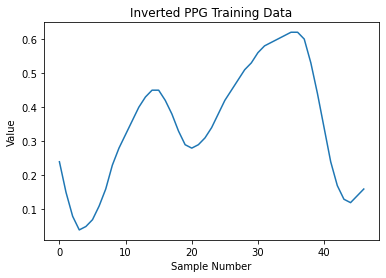

In [4]:
# Plot the training data
plt.plot(training_data)
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Inverted PPG Training Data')
plt.show()

In [5]:
# Read the CSV file into a pandas DataFrame
data = pd.read_csv('PPG2.csv')

# Extract the required columns
timestamp = data['sampleNum'][1000:]
bioz = data['BIOZ'][1000:]

# Specify the start and end indices of the data to analyze
start_index = 900  # Start index
end_index = 1200  # End index

# Clip the data within the specified range
bioz_clipped = bioz[start_index:end_index]
timestamp_clipped = timestamp[start_index:end_index]

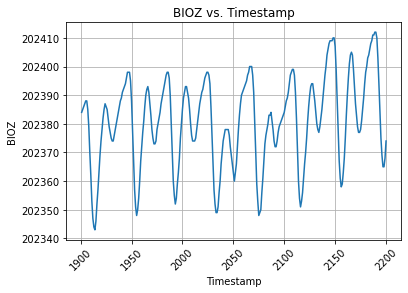

In [6]:
# Plot BIOZ values against Timestamp values
plt.plot(timestamp_clipped, bioz_clipped)
plt.xlabel('Timestamp')
plt.ylabel('BIOZ')
plt.title('BIOZ vs. Timestamp')
plt.xticks(rotation=45)
plt.grid(True)

In [7]:
# Smooth the data using a moving average
window_size = 5
smoothed_bioz = np.convolve(bioz_clipped, np.ones(window_size)/window_size, mode='valid')

In [8]:
# Prepare the data for classification
X_train = smoothed_bioz[:len(training_data)].reshape(-1, 1)

# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).long()

In [9]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=1, stride=1)  # Adjust stride for overlapping pooling
        self.conv2 = nn.Conv1d(16, 32, kernel_size=1, padding=0)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape the input tensor to (batch_size, num_features, sequence_length)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc(x)
        return x

In [10]:
# Create an instance of the CNN model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Create a DataLoader for batching the training data
train_dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [11]:
# Train the CNN model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [12]:
# Prepare the test data for prediction
X_test = smoothed_bioz[len(training_data):].reshape(-1, 1)
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.from_numpy(X_test_scaled).float()

# Get the predictions from the trained model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.unsqueeze(1))
    predicted = torch.argmax(outputs, dim=1)

In [13]:
# Find the positions of the first and last occurrence of the pattern
pattern_positions = np.where(predicted == 1)[0]
first_position = pattern_positions[0]
last_position = pattern_positions[-1]

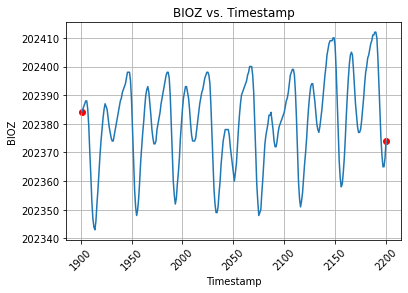

In [14]:
# Plot red dots at the first and last pattern positions
plt.scatter(timestamp_clipped.iloc[0], bioz_clipped.iloc[0], color='red')
plt.scatter(timestamp_clipped.iloc[-1], bioz_clipped.iloc[-1], color='red')
# Display the graph with red dots indicating pattern positions
plt.plot(timestamp_clipped, bioz_clipped)
plt.xlabel('Timestamp')
plt.ylabel('BIOZ')
plt.title('BIOZ vs. Timestamp')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()